In [3]:
from fastai.vision.all import *
from fastai.distributed import *
from fastai.data import load
from fastai.callback.tracker import SaveModelCallback
from fastprogress import fastprogress
import torch
from torchvision import datasets, transforms, models
import torchvision.transforms as T
import argparse
from models.utils.joiner2 import Joiner
from models.utils.new_losses import *
from models.utils.metrics import Accuracy, Curating_Of_Attention_Loss
#from models.utils.dataLoader import *
from models.utils.datasets import CustomCifar
from models.utils.datasets import *
import webdataset as wds

In [1]:
H = 32
W= 32
bs = 5
grid_l = 2
nclass = 10
backbone = False
epochs = 5

beta = 0.0005
gamma = 0.0005
sigma = 1.0

seed = 1234

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

H = 32
W= 32
bs=5

transform = T.Compose([
T.Resize((H,W)),
T.ToTensor()
#T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

NameError: name 'torch' is not defined

In [21]:
#sharedurl = "data/GramCifar/train/train_CustomCifar-{0..1}.tar"
#sharedurl_valid = "data/GramCifar/train/train_CustomCifar-2.tar"

sharedurl = "data/ILSVRC2012_img_train_t3.tar"
sharedurl_valid = "data/ILSVRC2012_img_val.tar"


normalize = transforms.Normalize(
  mean=[0.485, 0.456, 0.406],
  std=[0.485, 0.456, 0.406])

preproc = transforms.Compose([
  #transforms.RandomResizedCrop(224),
  #transforms.RandomHorizontalFlip(),
  transforms.Resize((H,W)),
  transforms.ToTensor(),
  normalize,
])

train = (
  wds.Dataset(sharedurl)
  .shuffle(1000)
  .decode("pil")
  .rename(image="jpg;png", data="json")
  .map_dict(image=preproc)
  .to_tuple("image", "data")
)

valid = (
  wds.Dataset(sharedurl)
  .shuffle(1000)
  .decode("pil")
  .rename(image="jpg;png", data="json")
  .map_dict(image=preproc)
  .to_tuple("image", "data")
)

In [22]:
#loader = torch.utils.data.DataLoader(dataset, batch_size=64, num_workers=8)

In [23]:
model = Joiner(num_encoder_layers = 6, nhead=8, backbone = backbone, num_classes = nclass, bypass=False, hidden_dim=256, 
          batch_size=bs, image_h=H, image_w=W, grid_l=grid_l,penalty_factor="2")

In [24]:
def CifarDataloader(train, valid):
        
        train_dl = load.DataLoader(train,batch_size=5)
        valid_dl = load.DataLoader(valid,batch_size=5)
        dld = ImageDataLoaders(train_dl, valid_dl, device='cuda')
        
        return dld

In [25]:
dloader = CifarDataloader(train, valid)

In [26]:
#dloader = CifarDataloader('data/CustomCifar', transforms=transform)
#dloader = CifarDataloader('data/CustomCifar/train_CustomCifarlen1000_startIdx40000.tar', transforms=transform)

NotImplementedError: 

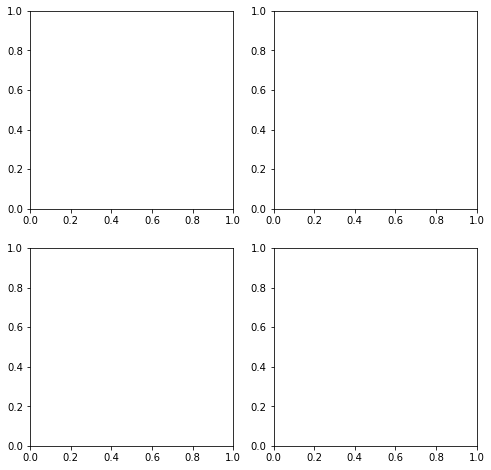

In [17]:
pix_h = 19
pix_w = 18
image = 4
f, axs = plt.subplots(2,2,figsize=(8,8))
plt.subplot(221)
plt.imshow(dloader.train_ds[image][0].cpu().permute(1, 2, 0))
plt.subplot(222)
plt.imshow(dloader.train_ds[image+5][0].cpu().permute(1, 2, 0))
plt.subplot(223)
plt.imshow(dloader.train_ds[image][1][0][pix_h,pix_w,...].cpu().detach().numpy(),cmap='cividis', interpolation='nearest')#,vmax=threshold)
plt.subplot(224)
plt.imshow(dloader.train_ds[image+5][1][0][pix_h,pix_w,...].cpu().detach().numpy(),cmap='cividis', interpolation='nearest')#,vmax=threshold)

In [18]:
critic_loss = CriticLoss(beta=0.000005, sigma=1)

In [19]:
learner = Learner(dloader, model, loss_func=critic_loss, metrics=[Accuracy])

In [20]:
learner.lr_find()

TypeError: rename() got multiple values for argument 'data'

In [11]:
learner.fit(epochs, 3e-7)

epoch,train_loss,valid_loss,Accuracy,time
0,2.186183,2.162832,0.182500,02:34
1,2.127582,2.078187,0.217500,02:34
2,2.042032,2.024552,0.235000,02:34
3,1.993963,1.978121,0.255000,02:34
4,1.964406,1.944676,0.266500,02:34
